In [45]:
from ibapi.sync_wrapper import *
import pandas as pd
import numpy as np
from pathlib import Path
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import akshare as ak

In [3]:
def bars2ohlcv(bars):
    df = pd.DataFrame.from_dict([{'date': int(bar.date), 'open': bar.open, 'high': bar.high, 'low': bar.low, 'close': bar.close, 'volume': bar.volume} for bar in bars])
    df['date'] = pd.to_datetime(df['date'], unit='s', utc=True)
    df.set_index('date', inplace=True)
    return df

In [4]:
def choice2ohlcv(dfr):
  dfr['交易时间'] = dfr['交易时间'].dt.tz_localize('Asia/Shanghai')
  dfr['UTC时间'] = dfr['交易时间'].dt.tz_convert('UTC')
  dfr.set_index('UTC时间', inplace=True)
  dfr.index.name = 'date'
  if '成交量' not in dfr.columns:
    dfr['成交量'] = 0
  dfr = dfr.rename(columns={'开盘价': 'open', '最高价': 'high', '最低价': 'low', '收盘价': 'close', '成交量': 'volume'})
  dfr = dfr[['open', 'high', 'low', 'close', 'volume']]
  return dfr.sort_index(ascending=True)

In [ ]:
def yf2ohlcv(dfr):
  label = dfr.columns.get_level_values(1).unique()[0]
  df = dfr.xs(label, axis=1, level=1)
  df.columns = ['close', 'high', 'low', 'open', 'volume']
  df.index = pd.to_datetime(df.index, utc=True)
  df.index.name = 'date'
  df = df[['open', 'high', 'low', 'close', 'volume']]
  return df.sort_index(ascending=True)

In [46]:
def akshare2ohlcv(dfr):
  dfr['date'] = pd.to_datetime(dfr['datetime'])
  dfr['date'] = dfr['date'].dt.tz_localize('Asia/Shanghai').dt.tz_convert('UTC')
  dfr.set_index('date', inplace=True)
  return dfr[['open', 'high', 'low', 'close', 'volume']]

In [5]:
def merge_df(df1, df2, df3):
    merged_df = pd.merge(df1, df2, left_index=True, right_index=True, how='inner', suffixes=('_1', '_2'))
    merged_df = pd.merge(merged_df, df3, left_index=True, right_index=True, how='inner')
    merged_df.rename(columns={'close_1': 'a0', 'close_2': 'b0', 'close': 'c0'}, inplace=True)
    return merged_df[['a0', 'b0', 'c0']]

In [54]:
def compare3symbols(symbols, duration, bar_size):
    c1, c2, c3 = symbols
    _, (df1, df2) = compare2symbols((c1, c2), duration, bar_size)
    df3 = get_historical_data(c3, duration, bar_size, "MIDPOINT")
    df = merge_df(df1, df2, df3)
    return df, (df1, df2, df3)

def compare2symbols(symbols, duration, bar_size):
    c1, c2 = symbols

    df1 = get_historical_data(c1, duration, bar_size, "TRADES")
    df2 = get_historical_data(c2, duration, bar_size, "TRADES")

    df = pd.merge(df1, df2, on='date', suffixes=('_1', '_2'), how='inner')
    return df, (df1, df2)

def get_historical_data(contract, duration, bar_size, up_to_date=True):
    use_rth = contract.secType == 'STK'
    what_to_show = 'MIDPOINT' if contract.exchange == 'IDEALPRO' else 'TRADES'

    symbol = contract.symbol if contract.exchange != 'IDEALPRO' else f'{contract.symbol}{contract.currency}'
    filepath = f'data/ibkr/{symbol}-{bar_size.replace(' ', '')}-{what_to_show}.csv'
    path = Path(filepath)
    if path.exists():
        dfe = pd.read_csv(filepath, index_col='date', parse_dates=True)
        now = pd.Timestamp.now(tz=dfe.index.tz)
        _duration = (now - dfe.index[0]).days
        if _duration < duration:
            days = duration
        else:
            days = (now - dfe.index[-1]).days + 1
    else:
        days = duration
        dfe = pd.DataFrame()
    
    # 不需要更新直接返回已有的数据
    if not up_to_date:
        return dfe
    
    dfn = bars2ohlcv(app.get_historical_data(
        contract=contract, 
        end_date_time="", 
        duration_str=days2duration(days),
        bar_size_setting=bar_size,
        what_to_show=what_to_show, 
        use_rth=use_rth,
        format_date=2,
        timeout=24*60*60))

    df = pd.concat([dfe, dfn])
    df = df[~df.index.duplicated(keep='first')]
    df = df.sort_index()
    df.to_csv(filepath)
    return df

def days2duration(days):
    if days >= 365:
        years = math.ceil(days / 365)
        return f"{years} Y"
    elif days >= 30:
        months = math.ceil(days / 30)
        return f"{months} M"
    else:
        return f"{days} D"

def futures_zh_minute_sina(symbol, bar_size, up_to_date=True):
    filepath = f'data/akshare/sina-{symbol}-{bar_size}mins.csv'
    path = Path(filepath)
    if path.exists():
        dfe = pd.read_csv(filepath, index_col='date', parse_dates=True)
    else:
        dfe = pd.DataFrame()

    if not up_to_date:
        return dfe
    
    dfn = akshare2ohlcv(ak.futures_zh_minute_sina(symbol=symbol, period=bar_size))

    df = pd.concat([dfe, dfn])
    df = df[~df.index.duplicated(keep='first')]
    df = df.sort_index()
    df.to_csv(filepath)
    return df

In [ ]:
app = TWSSyncWrapper(timeout=24 * 60 * 60)
app.connect_and_start(host="127.0.0.1", port=7496, client_id=1)
app.get_current_time()

# app.disconnect_and_stop()

In [8]:
USDJPY = Contract()
USDJPY.symbol = "USD"
USDJPY.secType = "CASH"
USDJPY.exchange = "IDEALPRO"
USDJPY.currency = "JPY"

USDCNH = Contract()
USDCNH.symbol = "USD"
USDCNH.secType = "CASH"
USDCNH.exchange = "IDEALPRO"
USDCNH.currency = "CNH"

GD = Contract()
GD.symbol = "GOLD"
GD.secType = "CONTFUT"
GD.exchange = "OSE.JPN"
GD.currency = "JPY"

M_PT = Contract()
M_PT.symbol = "M-PT"
M_PT.secType = "CONTFUT"
M_PT.exchange = "OSE.JPN"
M_PT.currency = "JPY"

PLAT = Contract()
PLAT.symbol = "PLAT"
PLAT.secType = "CONTFUT"
PLAT.exchange = "OSE.JPN"
PLAT.currency = "JPY"

GC = Contract()
GC.symbol = "GC"
GC.secType = "CONTFUT"
GC.exchange = "COMEX"
GC.currency = "USD"

MGC = Contract()
MGC.symbol = "MGC"
MGC.secType = "CONTFUT"
MGC.exchange = "COMEX"
MGC.currency = "USD"

_1OZ = Contract()
_1OZ.symbol = "1OZ"
_1OZ.secType = "CONTFUT"
_1OZ.exchange = "COMEX"
_1OZ.currency = "USD"

SI = Contract()
SI.symbol = "SI"
SI.secType = "CONTFUT"
SI.exchange = "COMEX"
SI.currency = "USD"

PL = Contract()
PL.symbol = "PL"
PL.secType = "CONTFUT"
PL.exchange = "NYMEX"
PL.currency = "USD"

PPLT = Contract()
PPLT.symbol = "PPLT"
PPLT.secType = "STK"
PPLT.exchange = "SMART"
PPLT.currency = "USD"

In [ ]:
df = get_historical_data(SI, 365, '5 mins', False)

In [ ]:
# df, _ = compare2symbols((PPLT, PL), '1 D', '5 mins')
# df['a-b'] = np.log(df['close_2']) - np.log(df['close_1'])

# df1 = choice2ohlcv(pd.read_excel('C:\\Users\\wayne\\Desktop\\kline\\基准\\AG0\\K线导出_AG0_60分钟线数据-251227.xlsx'))
df1 = yf2ohlcv(pd.read_csv('C:\\Users\\wayne\\Desktop\\kline\\基准\\SI-1H.csv', header=[0, 1], index_col=[0]))
df2 = get_historical_data(SI, '1 Y', '1 hour', "TRADES")

df= pd.merge(df1, df2, on='date', how='inner')
df['a'] = df['close_x']
df['b'] = df['close_y']
df['a-b'] = df['a'] - df['b']


In [7]:
# df, (df1, df2, df3) = compare3symbols((M_PT, PL, USDJPY), '1 D', '1 min')

In [55]:
# df1 = choice2ohlcv(pd.read_excel('C:\\Users\\wayne\\Desktop\\kline\\基准\\AG0\\K线导出_AG0_60分钟线数据-251227.xlsx'))
df1 = futures_zh_minute_sina("AG0", "60", up_to_date=False)
df2 = get_historical_data(SI, 365, '1 hour', up_to_date=False)
df3 = get_historical_data(USDCNH, 365, '1 hour', up_to_date=False)

df = merge_df(df1, df2, df3)

df['a'] = df['a0'] 
df['b'] = df['b0'] * df['c0'] * 1000 / 31.1034768
df['a-b'] = df['a'] - df['b']

relation: 0.9965078835490292
95%: -81.0538, 348.4889
N (228.8303, 213.2105)


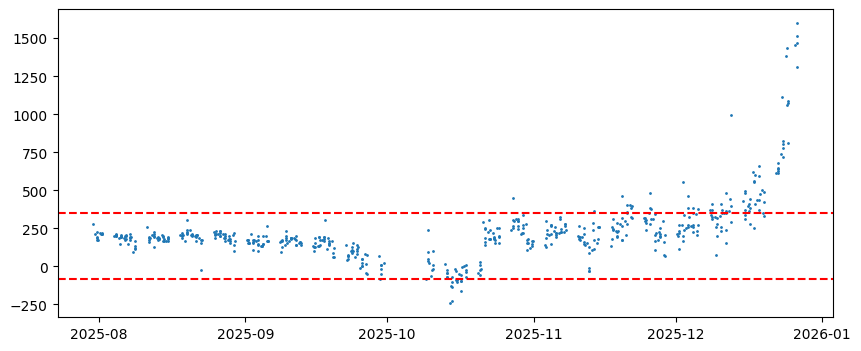

In [56]:
lower, upper = df[df.index < '2025-12-01']['a-b'].quantile([0.025, 0.975])
print(f'relation: {df['a'].corr(df['b'])}')
print(f'95%: {lower:.4f}, {upper:.4f}')
print(f'N ({df['a-b'].mean():.4f}, {df['a-b'].std():.4f})')

plt.figure(figsize=(10, 4))
plt.scatter(df.index, df['a-b'], s=1)
plt.axhline(y=lower, color='r', linestyle='--')
plt.axhline(y=upper, color='r', linestyle='--')
plt.show()